In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, get_dataset, info_plots
import shap
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Qualitative Response

# David Aponte

In [2]:
df = pd.read_csv("risk_factors_cervical_cancer.csv")
df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
Age                                   858 non-null int64
Number of sexual partners             858 non-null object
First sexual intercourse              858 non-null object
Num of pregnancies                    858 non-null object
Smokes                                858 non-null object
Smokes (years)                        858 non-null object
Smokes (packs/year)                   858 non-null object
Hormonal Contraceptives               858 non-null object
Hormonal Contraceptives (years)       858 non-null object
IUD                                   858 non-null object
IUD (years)                           858 non-null object
STDs                                  858 non-null object
STDs (number)                         858 non-null object
STDs:condylomatosis                   858 non-null object
STDs:cervical condylomatosis          858 non-null object
STDs:vaginal condylomatosi

# Introduction

For this task I will build an interpretable model that will help better understand the relationship between risk factors and cervical cancer. Alongside interpreting the model the goal is to develop a model that accurately predict whether or not a patient has a positive biopsy result.

Data can be found here: https://archive.ics.uci.edu/ml/machine-learning-databases/00383/

# Agenda

- Data cleaning
- EDA
- Baseline
- Interpretation of model
- Resampling the data
- Clustering
- Conclusion

# Target 

We will use 'Biopsy' as the target variable.

# Data Fields


- Age
- Number of sexual partners
- First sexual intercourse
- Num of pregnancies
- Smokes
- Smokes (years)
- Smokes (packs/year)
- Hormonal Contraceptives
- Hormonal Contraceptives (years)
- IUD
- IUD (years)
- STDs
- STDs (number)
- STDs:condylomatosis
- STDs:cervical condylomatosis
- STDs:vaginal condylomatosis
- STDs:vulvo-perineal condylomatosis
- STDs:syphilis
- STDs:pelvic inflammatory disease
- STDs:genital herpes
- STDs:molluscum contagiosum
- STDs:AIDS
- STDs:HIV
- STDs:Hepatitis B
- STDs:HPV
- STDs: Number of diagnosis
- STDs: Time since first diagnosis
- STDs: Time since last diagnosis
- Dx:Cancer
- Dx:CIN
- Dx:HPV
- Dx
- Hinselmann
- Schiller
- Citology
- Biopsy

# Data Cleaning


The data first needs to cleaned and preprocessed for modeling and efficiency.

In [4]:
df.dtypes.value_counts()

object    26
int64     10
dtype: int64

In [5]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,858,NaN,NaN,NaN,26.8205,8.49795,13,20,25,32,84
Number of sexual partners,858,13,2.0,272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
First sexual intercourse,858,22,15.0,163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Num of pregnancies,858,12,1.0,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Smokes,858,3,0.0,722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Smokes (years),858,31,0.0,722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Smokes (packs/year),858,63,0.0,722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hormonal Contraceptives,858,3,1.0,481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hormonal Contraceptives (years),858,41,0.0,269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IUD,858,3,0.0,658,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# preprocess for cleaning
def preprocess(df):
    """
    Preprocess data for EDA, modeling, etc.
    """
    # replace question marks with NaNs
    df = df.replace("?", np.nan)
    # convert object type to numeric
    df = df.apply(pd.to_numeric)
    # downcast to int32, not necessary but good practice
    # for making things faster
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# verify
df = preprocess(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
Age                                   858 non-null int32
Number of sexual partners             832 non-null float32
First sexual intercourse              851 non-null float32
Num of pregnancies                    802 non-null float32
Smokes                                845 non-null float32
Smokes (years)                        845 non-null float32
Smokes (packs/year)                   845 non-null float32
Hormonal Contraceptives               750 non-null float32
Hormonal Contraceptives (years)       750 non-null float32
IUD                                   741 non-null float32
IUD (years)                           741 non-null float32
STDs                                  753 non-null float32
STDs (number)                         753 non-null float32
STDs:condylomatosis                   753 non-null float32
STDs:cervical condylomatosis          753 non-null float32
STDs:vaginal

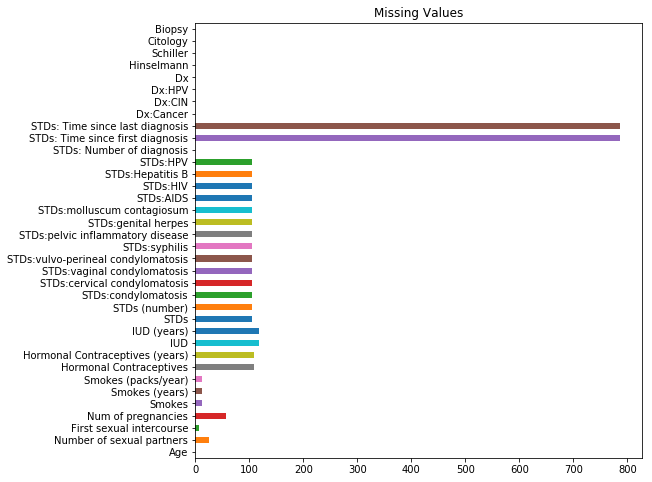

In [7]:
plt.figure(figsize=(8, 8))
df.isnull().sum().plot(kind='barh')
plt.title('Missing Values')
plt.show()

# EDA

I will now explore the data, looking for patterns and generating hypothesis about the data.

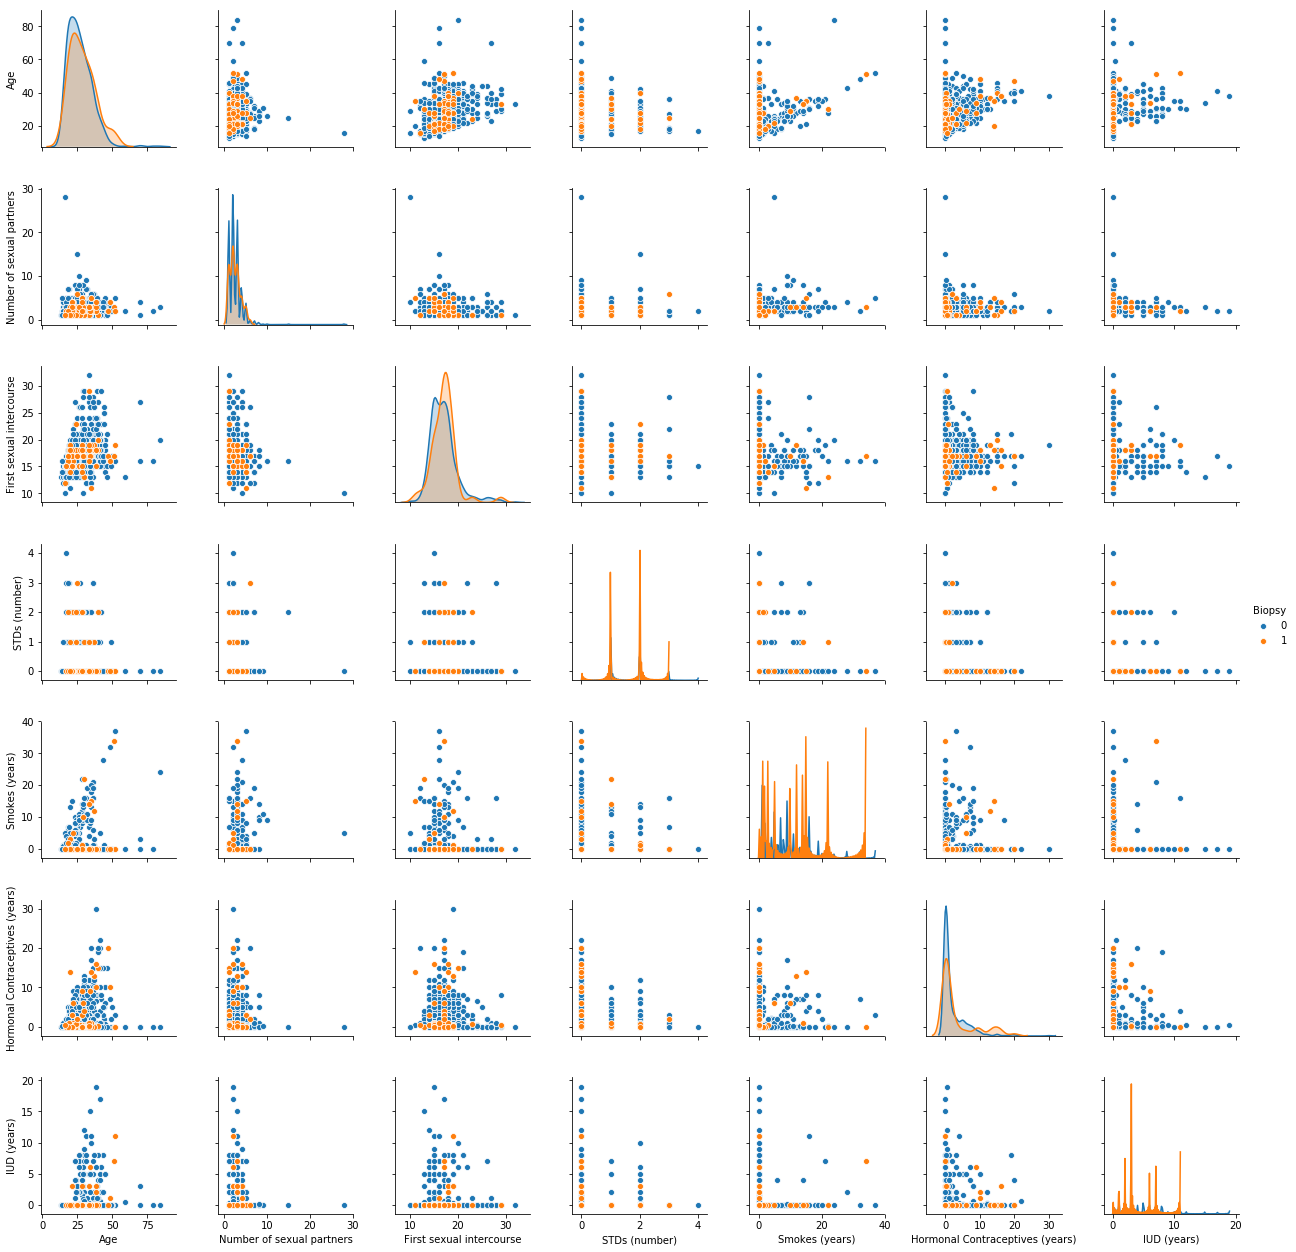

In [8]:
# plotting distributions
import seaborn as sns

# exploring a subset of the features
feats = ['Age', 'Number of sexual partners', 
        'First sexual intercourse', 'STDs (number)', 
        'Smokes (years)', 'Hormonal Contraceptives (years)','IUD (years)']

sns.pairplot(df, 
             x_vars = feats,
             y_vars = feats,
             hue='Biopsy')

def plot_dists(df, features=feats):
    """
    plot scattermatrix
    """
    sns.pairplot(df, x_vars = features, y_vars = features, hue='Biopsy')   

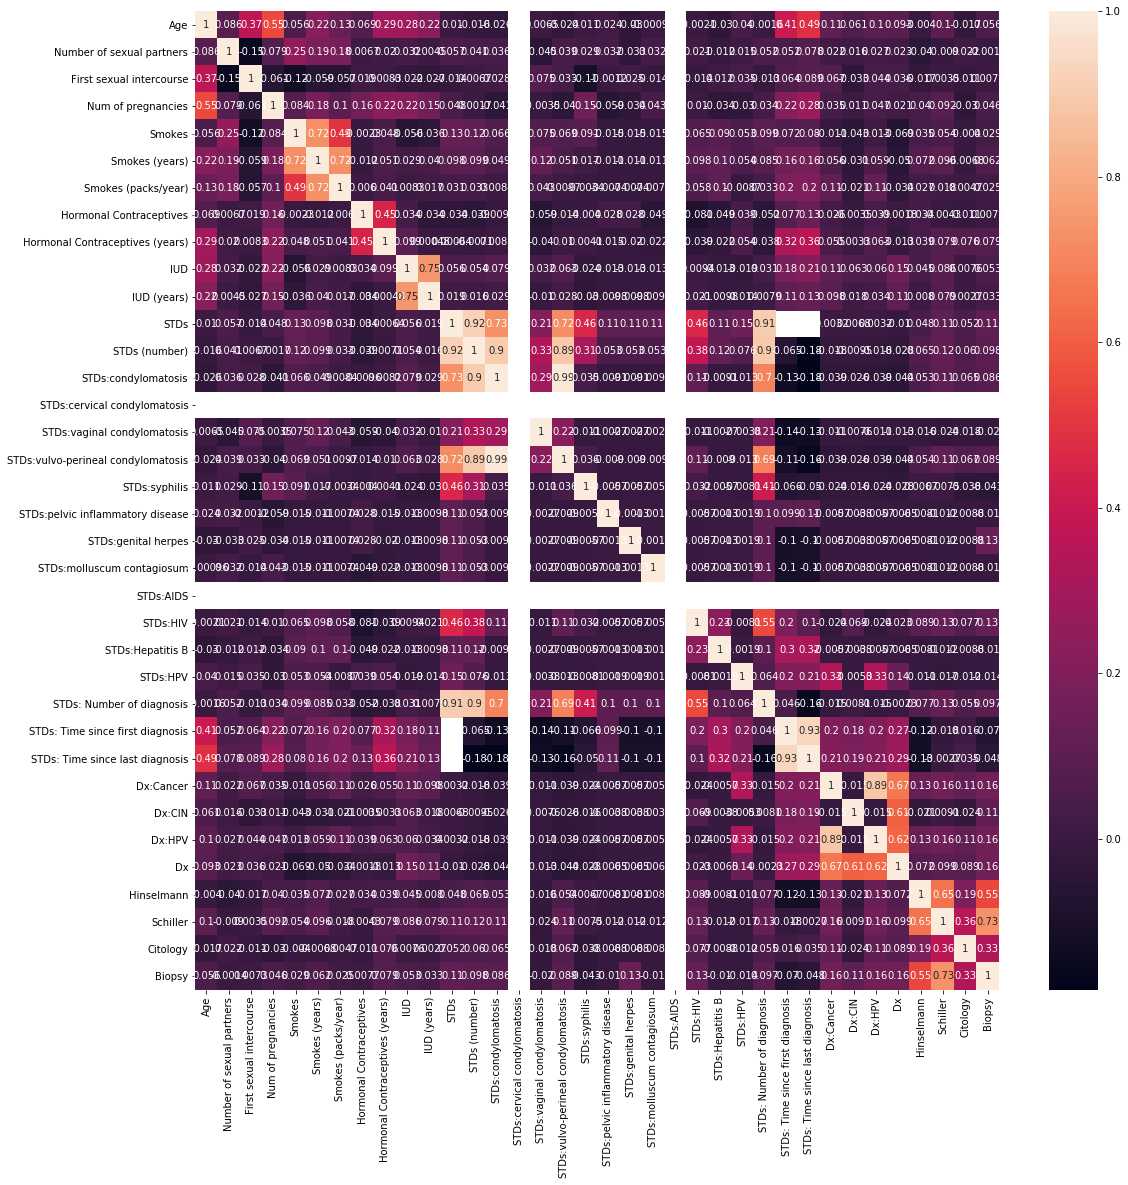

In [9]:
# plotting correlations

def plot_correlations(df):
    corr = df.corr()
    plt.figure(figsize=(18,18))
    sns.heatmap(corr, annot=True)
# plot    
plot_correlations(df)

In [10]:
# finding unique counts
def unique_counts(df):
   for i in df.columns:
       count = df[i].nunique()
       print(i, ": ", count)
unique_counts(df)

Age :  44
Number of sexual partners :  12
First sexual intercourse :  21
Num of pregnancies :  11
Smokes :  2
Smokes (years) :  30
Smokes (packs/year) :  62
Hormonal Contraceptives :  2
Hormonal Contraceptives (years) :  40
IUD :  2
IUD (years) :  26
STDs :  2
STDs (number) :  5
STDs:condylomatosis :  2
STDs:cervical condylomatosis :  1
STDs:vaginal condylomatosis :  2
STDs:vulvo-perineal condylomatosis :  2
STDs:syphilis :  2
STDs:pelvic inflammatory disease :  2
STDs:genital herpes :  2
STDs:molluscum contagiosum :  2
STDs:AIDS :  1
STDs:HIV :  2
STDs:Hepatitis B :  2
STDs:HPV :  2
STDs: Number of diagnosis :  4
STDs: Time since first diagnosis :  18
STDs: Time since last diagnosis :  18
Dx:Cancer :  2
Dx:CIN :  2
Dx:HPV :  2
Dx :  2
Hinselmann :  2
Schiller :  2
Citology :  2
Biopsy :  2


In [11]:
# temporarily impute missing values
# clean
clean = df.fillna(df.mean())
# verify
clean.isnull().sum()

Age                                   0
Number of sexual partners             0
First sexual intercourse              0
Num of pregnancies                    0
Smokes                                0
Smokes (years)                        0
Smokes (packs/year)                   0
Hormonal Contraceptives               0
Hormonal Contraceptives (years)       0
IUD                                   0
IUD (years)                           0
STDs                                  0
STDs (number)                         0
STDs:condylomatosis                   0
STDs:cervical condylomatosis          0
STDs:vaginal condylomatosis           0
STDs:vulvo-perineal condylomatosis    0
STDs:syphilis                         0
STDs:pelvic inflammatory disease      0
STDs:genital herpes                   0
STDs:molluscum contagiosum            0
STDs:AIDS                             0
STDs:HIV                              0
STDs:Hepatitis B                      0
STDs:HPV                              0


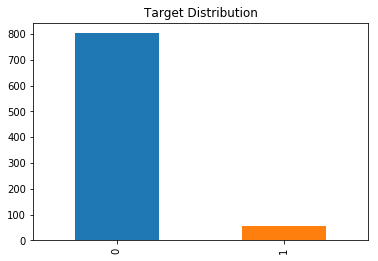

In [12]:
# target
clean.Biopsy.value_counts().plot(kind='bar')
plt.title("Target Distribution")
plt.show()

In [13]:
# proportion
clean.Biopsy.value_counts()

0    803
1     55
Name: Biopsy, dtype: int64

There are correlations between some of the features so this probably can be captured automatically using a random forest. Lets set up a baseline score.

# Baseline


#### Validation Approach:

Since we have a fairly small sample of patients I would like to split the dataset into a training and testing set. To asses my models generalization performance, I will use the K-fold scheme.

In [14]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# using 80% for training, 20% for testing, stratify for imbalance
X_train, X_test, y_train, y_test = train_test_split(clean.drop('Biopsy', axis=1), clean['Biopsy'], test_size=0.2, random_state=123, stratify=clean['Biopsy'], shuffle=True)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(686, 35) (172, 35)
(686,) (172,)


In [15]:
# baseline with LogisticRegression and RandomForest
rf = RandomForestClassifier(n_estimators=500, random_state=123).fit(X_train, y_train)

logreg = LogisticRegression(random_state=123).fit(X_train, y_train)

In [16]:
# import useful metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, recall_score, precision_score

# make predictions using test set
rf_preds = rf.predict(X_test)

logreg_preds = logreg.predict(X_test)

# confusion matrix
rf_cm = confusion_matrix(rf_preds, y_test)

logreg_cm = confusion_matrix(logreg_preds, y_test)

# recall for true positives
rf_recall = recall_score(rf_preds, y_test)

logreg_recall = recall_score(logreg_preds, y_test)

# precision for true negatives
rf_precision = precision_score(rf_preds, y_test)

logreg_precision = precision_score(logreg_preds, y_test)

In [17]:
# plot confusion matrix

def plot_confmatr(cm, classNames=['No Cancer', 'Cancer']):
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()


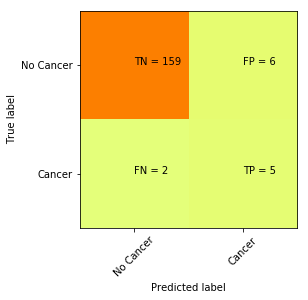

In [18]:
# random forest
plot_confmatr(rf_cm)

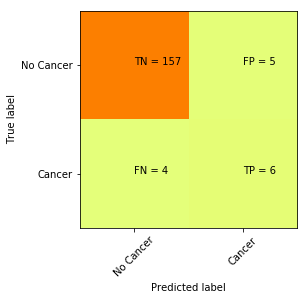

In [19]:
# log reg
plot_confmatr(logreg_cm)

In [20]:
# random forest
print(classification_report(rf_preds, y_test))
print(roc_auc_score(rf_preds, y_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       165
           1       0.45      0.71      0.56         7

   micro avg       0.95      0.95      0.95       172
   macro avg       0.72      0.84      0.77       172
weighted avg       0.97      0.95      0.96       172

0.838961038961039


In [21]:
# log reg
print(classification_report(logreg_preds, y_test))
print(roc_auc_score(logreg_preds, y_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       162
           1       0.55      0.60      0.57        10

   micro avg       0.95      0.95      0.95       172
   macro avg       0.76      0.78      0.77       172
weighted avg       0.95      0.95      0.95       172

0.784567901234568


#### Findings

The model as of now is biased against patients who dont have cancer. This makes sense since about 94% of the patients don't have cancer, so its not surprising given the nature of this dataset. But also, remembering the practical application of this project, the goal is to have an interpretable model that is able to accurately predict whether or not a patient has cancer. So, we want to reduce the number of false positives (saying they have cancer when they dont) and ensure that our model isnt biased against any minority patients.

Upsampling the data could help with this. 

In [22]:
from sklearn.utils import resample
# split into majority and minority
df_majority = clean[clean.Biopsy==0]
df_minority = clean[clean.Biopsy==1]
 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=803,    # to match majority class
                                 random_state=123) 
 
# combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# display new class counts
df_upsampled.Biopsy.value_counts()

1    803
0    803
Name: Biopsy, dtype: int64

This increased the number of observations, but it also balanced the classes.

In [23]:
# resplit
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(df_upsampled.drop('Biopsy', axis=1), df_upsampled.Biopsy, test_size=0.2, random_state=123)

print(X_train_up.shape, X_test_up.shape)
print(y_train_up.shape, y_test_up.shape)

(1284, 35) (322, 35)
(1284,) (322,)


In [24]:
# retrain and predict
# baseline with LogisticRegression and RandomForest
rf = RandomForestClassifier(n_estimators=500, random_state=123).fit(X_train_up, y_train_up)

logreg = LogisticRegression(random_state=123).fit(X_train_up, y_train_up)

rf_preds_up = rf.predict(X_test_up)

logreg_preds_up = logreg.predict(X_test_up)

In [25]:
# rf cm with unsampled data
print(classification_report(rf_preds_up, y_test_up))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       140
           1       1.00      0.96      0.98       182

   micro avg       0.98      0.98      0.98       322
   macro avg       0.98      0.98      0.98       322
weighted avg       0.98      0.98      0.98       322



In [26]:
# log reg cm with upsampled data
print(classification_report(logreg_preds_up, y_test_up))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93       151
           1       0.93      0.95      0.94       171

   micro avg       0.93      0.93      0.93       322
   macro avg       0.93      0.93      0.93       322
weighted avg       0.93      0.93      0.93       322



#### Findings

Upsampling the data drastically improved the models overall performance - for both linear and tree-based methods. Now I want to look closer into the models to understand what features are important for predicting whether or not a patient has cancer. It also appears as if a tree-based model will work best on this dataset. It could be due to interactions between the features (multicollinearity) which is better captured by the RandomForestClassifier.

# Permutation Importance

I want to look at feature importance using permuation importances, which works by randomly shuffling each of the features and calculating how much that affects the prediction/accuracy of the model. Using the <code>eli5</code> library you can easily implement this. To better understand the data (which is important for this project) I will evalute permutation importances with both tree and linear models.


####  Random Forest Permutation Importance 

In [28]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=123).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0895 ± 0.0216,Schiller
0.0058 ± 0.0000,First sexual intercourse
0.0047 ± 0.0047,Age
0.0012 ± 0.0047,Num of pregnancies
0.0012 ± 0.0047,Citology
0 ± 0.0000,Dx:CIN
0 ± 0.0000,STDs (number)
0 ± 0.0000,STDs
0 ± 0.0000,IUD (years)
0 ± 0.0000,IUD


In [29]:
perm = PermutationImportance(logreg, random_state=123).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0942 ± 0.0047,Schiller
0.0174 ± 0.0147,STDs: Time since first diagnosis
0.0093 ± 0.0057,STDs: Time since last diagnosis
0.0035 ± 0.0057,Smokes (packs/year)
0 ± 0.0000,STDs:HIV
0 ± 0.0000,STDs (number)
0 ± 0.0000,STDs:condylomatosis
0 ± 0.0000,STDs:cervical condylomatosis
0 ± 0.0000,STDs:vaginal condylomatosis
0 ± 0.0000,STDs:vulvo-perineal condylomatosis


#### Findings

- Schiller is important to both models. 
- Citology was important to both.
- Contraceptives
- IUD
- Smokes(Packs/Years)
- Number of sexual partners was more important to the random forest
- Number of pregnancies was important to the random forest


It makes sense that Schiller, Citology, and Hinselmann are important features because they are all proxies for the target variable - so those features arent going to be used in the model as that would lead to leakage. But some of the features such as IUD, Hormonal Contraceptives (years), and Number of sexual partners are all important predictors that we can use. 

Now upon evaluation these features corroborate what current research says about cervical cancer - w.r.t to them being known risk factors that lead to a positive biopsy result. So I will be sure to use these predictors. 

# Partial Dependence Plots

Now I want to take a look at partial dependence plots to see how these features affect predictions. This is a bit different from showing what variables most affected predictions. Partial dependent plots are useful to answer some questions I have - e.g. controlling all other features, what impact does the use of contraceptives have on having a positive biopsy? To do this I'll use a single patient (row) from the dataset and see how it affected the model. Lets start with the random forest.


#### Random Forest Partial Dependence Plots

/Users/davidaponte/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/davidaponte/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/davidaponte/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/davidaponte/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


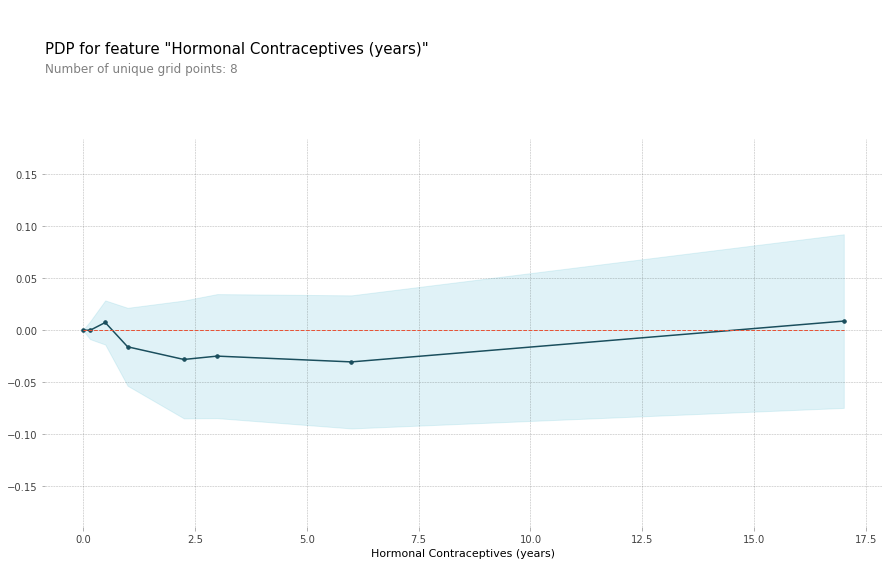

In [30]:
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns.tolist(), feature='Hormonal Contraceptives (years)')

# plot it
pdp.pdp_plot(pdp_goals, 'Hormonal Contraceptives (years)')
plt.show()

The PDP library works by repeatedly altering the value of the Hormonal Contraceptives (years) (feature) and making a series of predictions, measuring how it changes the prediction (y-axis). According to this plot, the longer you take contraceptives, the more likely you are to have cervical cancer.

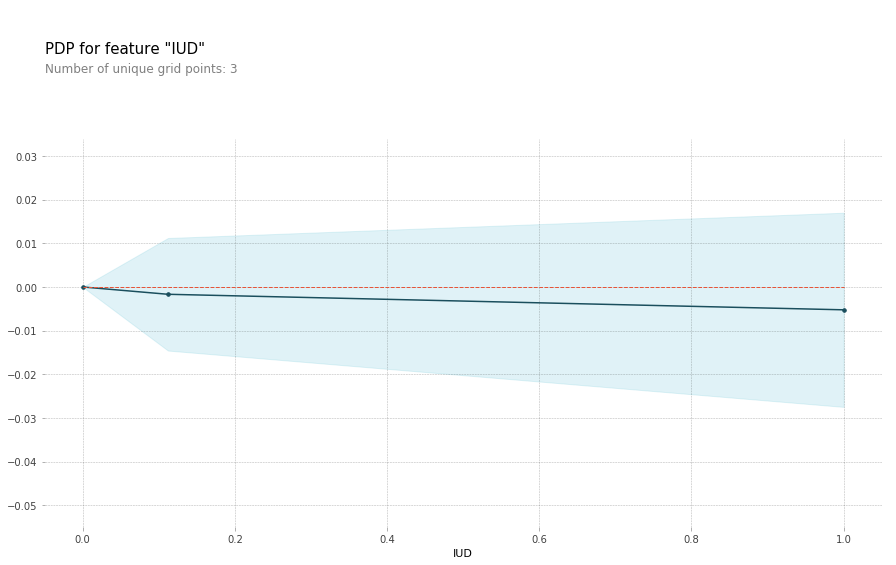

In [31]:
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns.tolist(), feature='IUD')

# plot it
pdp.pdp_plot(pdp_goals, 'IUD')
plt.show()

Looks like using an IUD decreases the chance of getting cancer but after a certain point it has little impact.

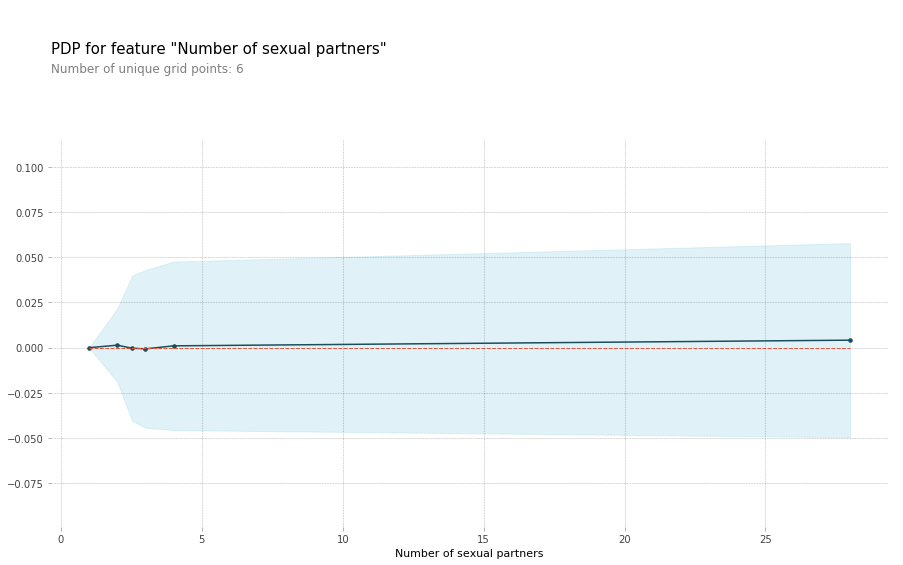

In [32]:
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns.tolist(), feature='Number of sexual partners')

# plot it
pdp.pdp_plot(pdp_goals, 'Number of sexual partners')
plt.show()


As you increase the number of sexual partners you slowly increase your chances of getting cancer. The slope of this line is increasing slowly and may eventually level out, thereby, indicating that feature has a small impact. 

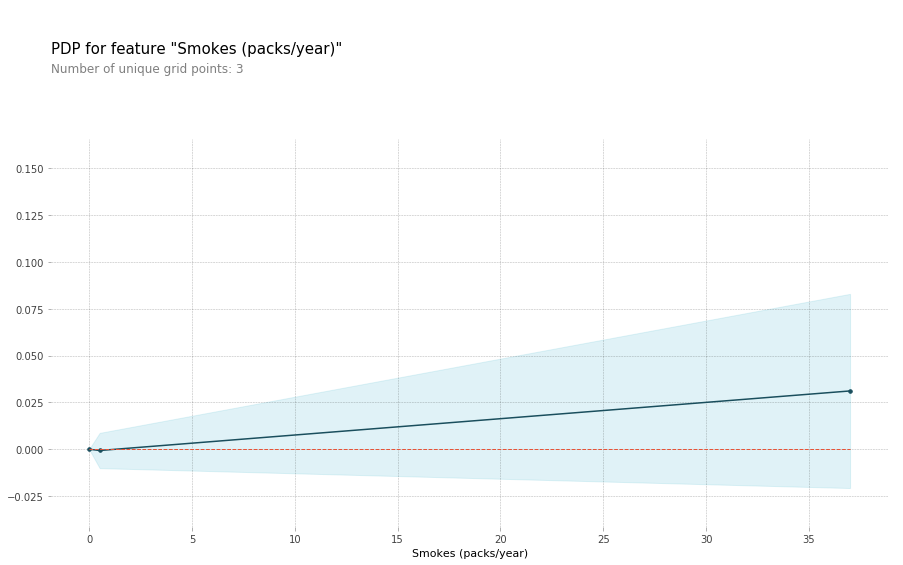

In [33]:
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns.tolist(), feature='Smokes (packs/year)')

# plot it
pdp.pdp_plot(pdp_goals, 'Smokes (packs/year)')
plt.show()

As the rate of smoking increases, your chances of getting cancer increase as well. You can see that the change is steadily increasing but not by much.

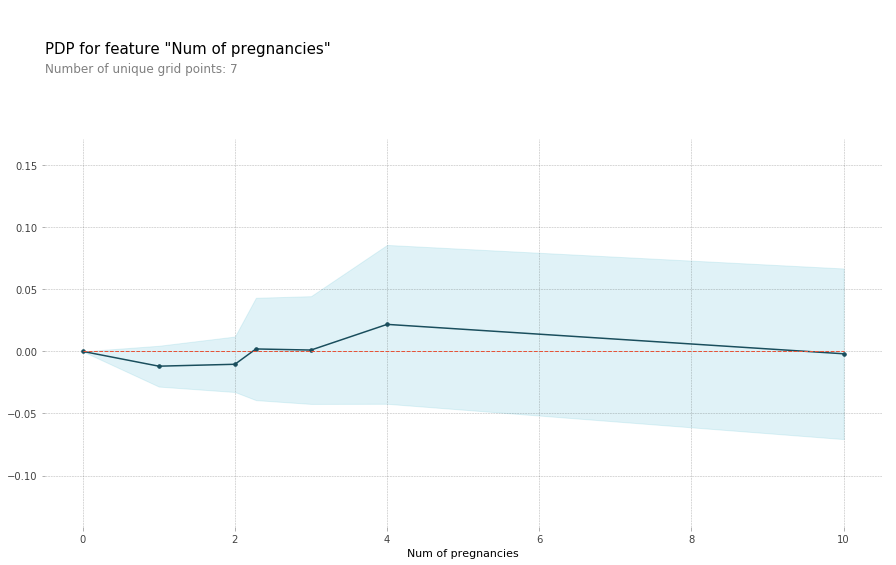

In [34]:
pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, model_features=X_test.columns.tolist(), feature='Num of pregnancies')

# plot it
pdp.pdp_plot(pdp_goals, 'Num of pregnancies')
plt.show()

There is a bit of variation in this plot. As you increase the number of pregnancies your chances of getting cancer decrease and then increase and then eventually make little difference.

/Users/davidaponte/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


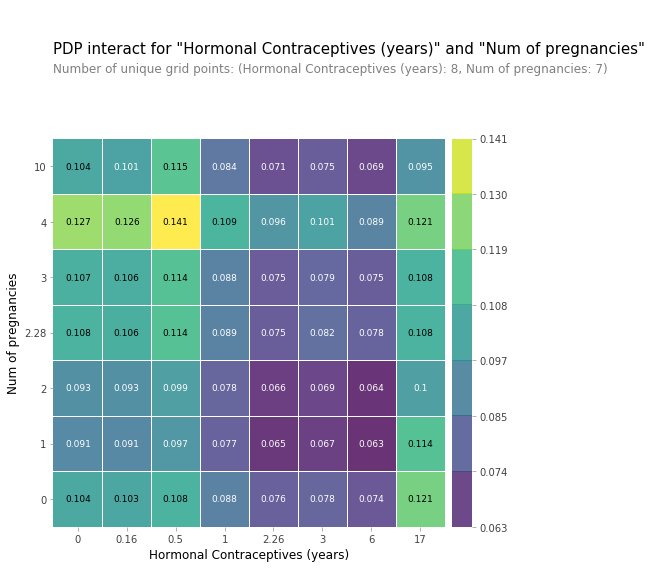

In [35]:
features_to_plot = ['Hormonal Contraceptives (years)', 'Num of pregnancies']
inter1  =  pdp.pdp_interact(model=rf, dataset=X_test, model_features=X_test.columns.tolist(), features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

The features do interact but that does make sense as women often regulate their pregnancies using contrceptives.


#### Findings

Looking at the plots you can see how they are affecting predictions and thereby better understanding what the random forest is doing. I chose not to plot any PDP plots for the logistic regression model because it had very low permutation importance scores thereby telling me that a linear model probably isnt best for this type of classification problem. This makes sense since the tree-based model performed better at predicting whether or not a patient had cancer given they were tested positive for their biopsy (true positives).

# SHAP Values

Now I want to see how the model is working for an individual prediction. We can find out using SHAP Values (SHapley Additive exPlanations) to better understand a prediction and see the impact of each feature. Given that this dataset has direct application into the medical industry we can use these values to directly address the risk factors with medical care.

Lets use a single row (7) and make predictions for it.

In [36]:
# for the 7th patien
row = 7
data_for_pred = X_test.iloc[row]

# reshape for prediction
data_for_pred.values.reshape(1, -1)

array([[34.        ,  4.        , 18.        ,  4.        ,  1.        ,
         8.        ,  2.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  6.1408453 ,  5.81690121,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [37]:
# predict probability for 7th patient
rf.predict_proba(data_for_pred.values.reshape(1, -1))

array([[0.984, 0.016]])

This patient has a 98.4% probability of not having cervical cancer and a 1.6% chance of having cancer. Now to the SHAP values. 

In [38]:
# explainer object
explainer = shap.TreeExplainer(rf)

# calculate
shap_values = explainer.shap_values(data_for_pred)

# visualize
shap.initjs()

shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_pred)

### Findings

The SHAP values show that having no STDs, a minimum of 4 sexual partners, being a smoker for at least 8 years and smokes a minimum of 2 packs/year, do not take hormonal contraceptives, had your first sexual intercourse at the age of 18 and are around 34 years old, all push the prediction higher (red).

It also shows that having a number of 4 pregnanices push the prediction lower (blue). The baseline score was 0.5105 and we predicted 0.98. The features in red pushed the model from the baseline score to the predicted output (0.98); the features in blue pushed the model away from the baseline score. 

We can thereby use these values to better understand how the features are working for a specific prediction.

In [39]:
#from imblearn.combine import SMOTETomek

# Modeling

In [40]:
feats = ['Age', 
         'Number of sexual partners', 
         'First sexual intercourse', 
         'Num of pregnancies',
        'Smokes (packs/year)',
        'Hormonal Contraceptives (years)',
         'IUD',
        'STDs']

# train test split
X_train, X_test, y_train, y_test = train_test_split(clean[feats], clean['Biopsy'], stratify=clean['Biopsy'], test_size=0.2)

In [41]:
X_train.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (packs/year)',
       'Hormonal Contraceptives (years)', 'IUD', 'STDs'],
      dtype='object')

In [42]:
X_train.shape

(686, 8)

In [43]:
X_test.shape

(172, 8)

Stratified K-fold cross-validation

In [44]:
from sklearn.model_selection import StratifiedKFold

# 3 splits
skfold = StratifiedKFold(n_splits=3)

# x, y
X = df_upsampled[feats].values
y = df_upsampled['Biopsy'].values

# split data
for train, test in skfold.split(X, y):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1072, 8), (534, 8), (1072,), (534,))

In [45]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7
0,18.0,4.0,15.0000,1.0,0.0,0.0,0.0,0.0
1,15.0,1.0,14.0000,1.0,0.0,0.0,0.0,0.0
2,34.0,1.0,16.9953,1.0,0.0,0.0,0.0,0.0
3,52.0,5.0,16.0000,4.0,37.0,3.0,0.0,0.0
4,46.0,3.0,21.0000,4.0,0.0,15.0,0.0,0.0


In [46]:
# set up model
model = RandomForestClassifier(n_estimators=1000, random_state=123)
# train
model.fit(X_train, y_train)
# make predictions
preds = model.predict(X_test)

In [47]:
print(classification_report(preds, y_test))
cm = confusion_matrix(preds, y_test)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       252
           1       1.00      0.95      0.97       282

   micro avg       0.97      0.97      0.97       534
   macro avg       0.97      0.97      0.97       534
weighted avg       0.97      0.97      0.97       534



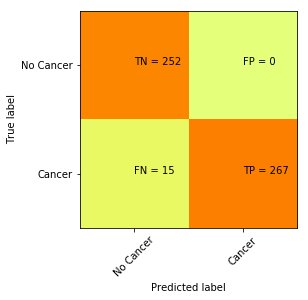

In [48]:
plot_confmatr(cm)

# Summary

The model so far has zero false-positives which is great but still has some false negatives - meaning the model said the patient didnt have cancer when in reality they did. But given the high recall and sensitivity (and with the help of earlier analysis, intepretability) we can still use this model to assists physicians with diagnosis.

# Clustering

Now that I have built a model with good performance I would like to try applying an unsupervised technique to the dataset and see if we can create clusters to use an inputs for the model. 

In order to find the optimal number of clusters I'll use the elbow plot method to visually identify the point at which the inertia begins to form an "elbow" - this signifies the optimal number of clusters.

In [49]:
from sklearn.cluster import KMeans

# range of clusters
ks = list(range(1,30))
# inertias
inertia = []

for i in ks:
    kmean = KMeans(n_clusters=i)
    kmean.fit(X_train, y_train)
    inertia.append(kmean.inertia_)

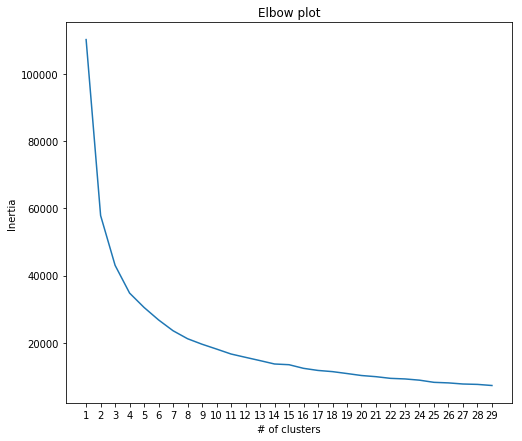

In [50]:
# plot
plt.figure(figsize=(8,7))
plt.plot(ks, inertia)
plt.xticks(ks)
plt.title("Elbow plot")
plt.xlabel("# of clusters")
plt.ylabel("Inertia")
plt.show()

Looks like the inertia begins to decrease and form an elbow around 4 clusters. Using that information I'll now create a new feature with the cluster numbers and well see how that affects the model performance. 

In [52]:
from sklearn.model_selection import cross_val_predict

# using 4 clusters
kmean = KMeans(n_clusters=4)
# train
kmean.fit(X_train, y_train)
# generate training features using cross k-fold cross-validation to reduce variance
kmean_pred = cross_val_predict(kmean, X_train, y_train, cv=skfold)

In [53]:
# test set
kmean = KMeans(n_clusters=4)
# train
kmean.fit(X_train, y_train)
# predict with test set
kmean_test_pred = kmean.predict(X_test)

In [54]:
# hstack features and reshape
X_train_w_cluster = np.hstack((X_train, kmean_pred.reshape(-1, 1)))
X_test_w_cluster = np.hstack((X_test, kmean_test_pred.reshape(-1, 1)))

In [55]:
# set up model
model2 = RandomForestClassifier(n_estimators=1000, random_state=0)
# train
model2.fit(X_train_w_cluster, y_train)
# make predictions
preds2 = model2.predict(X_test_w_cluster)

print(classification_report(preds2, y_test))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       245
           1       1.00      0.92      0.96       289

   micro avg       0.96      0.96      0.96       534
   macro avg       0.96      0.96      0.96       534
weighted avg       0.96      0.96      0.96       534



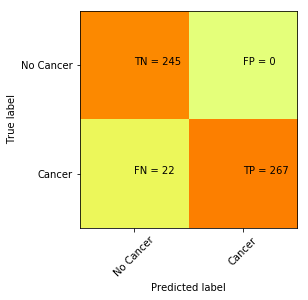

In [56]:
# plot confusion matrix
cm = confusion_matrix(preds2, y_test)
plot_confmatr(cm)

# Conclusion

Creating new features using clusters didnt improve the model, but it may be useful for future analyses and generating new features. Overall, the model trained using the upsampled dataset and a subset of the features performed best. Using this model, we can now accurately predict whether or not a patient has cervical cancer; and we can use a variety of tools (such as SHAP values, permutation importances, etc.) to better understand what the model is doing "under the hood". This can be very useful when combined with a practioners wisdom and pracical experience. 

# Future Work

Future work may include the following:

- Generating new features and further improving the models predictive performance.
- Testing different models such as neural networks, gradient boosting decision trees, etc.

